In [1]:
from scipy import stats
import random
from itertools import compress
from statistics import mean
import statsmodels.api as sm
import statsmodels.imputation.mice as mice
import pylab as py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from IPython.display import display, HTML
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
df1 = pd.read_csv("../Project/housing_data.csv") 
print("There are",df1.shape[0],"rows and",df1.shape[1],"columns in dataset.")
print("\nColumn names:\n", df1.columns.values)

There are 1338 rows and 75 columns in dataset.

Column names:
 ['Id' 'MSSubClass' 'MSZoning' 'LotArea' 'Street' 'LotShape' 'LandContour'
 'Utilities' 'LotConfig' 'LandSlope' 'Neighborhood' 'Condition1'
 'Condition2' 'BldgType' 'HouseStyle' 'OverallQual' 'OverallCond'
 'YearBuilt' 'YearRemodAdd' 'RoofStyle' 'RoofMatl' 'Exterior1st'
 'Exterior2nd' 'MasVnrType' 'MasVnrArea' 'ExterQual' 'ExterCond'
 'Foundation' 'BsmtQual' 'BsmtCond' 'BsmtExposure' 'BsmtFinType1'
 'BsmtFinSF1' 'BsmtFinType2' 'BsmtFinSF2' 'BsmtUnfSF' 'TotalBsmtSF'
 'Heating' 'HeatingQC' 'CentralAir' 'Electrical' '1stFlrSF' '2ndFlrSF'
 'LowQualFinSF' 'GrLivArea' 'BsmtFullBath' 'BsmtHalfBath' 'FullBath'
 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr' 'KitchenQual' 'TotRmsAbvGrd'
 'Functional' 'Fireplaces' 'GarageType' 'GarageYrBlt' 'GarageFinish'
 'GarageCars' 'GarageArea' 'GarageQual' 'GarageCond' 'PavedDrive'
 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch' '3SsnPorch' 'ScreenPorch'
 'PoolArea' 'MiscVal' 'MoSold' 'YrSold' 'SaleType' '

In [3]:
df1['MSSubClass'] = df1['MSSubClass'].astype('object')
#MSSubClass is given as categorical in description. 

In [4]:
i,j = 0,0
for column in df1:
    if df1[column].dtype == object:
        i = i+1
    else:
        j = j+1
    print(column, df1[column].dtype)
print("\nThere are", i, "categorical and", j, "numeric variables." )

Id int64
MSSubClass object
MSZoning object
LotArea int64
Street object
LotShape object
LandContour object
Utilities object
LotConfig object
LandSlope object
Neighborhood object
Condition1 object
Condition2 object
BldgType object
HouseStyle object
OverallQual int64
OverallCond int64
YearBuilt int64
YearRemodAdd int64
RoofStyle object
RoofMatl object
Exterior1st object
Exterior2nd object
MasVnrType object
MasVnrArea float64
ExterQual object
ExterCond object
Foundation object
BsmtQual object
BsmtCond object
BsmtExposure object
BsmtFinType1 object
BsmtFinSF1 int64
BsmtFinType2 object
BsmtFinSF2 int64
BsmtUnfSF int64
TotalBsmtSF int64
Heating object
HeatingQC object
CentralAir object
Electrical object
1stFlrSF int64
2ndFlrSF int64
LowQualFinSF int64
GrLivArea int64
BsmtFullBath int64
BsmtHalfBath int64
FullBath int64
HalfBath int64
BedroomAbvGr int64
KitchenAbvGr int64
KitchenQual object
TotRmsAbvGrd int64
Functional object
Fireplaces int64
GarageType object
GarageYrBlt float64
GarageFinish

In [5]:
df1["SalePrice"].describe()

count      1338.000000
mean     186761.782511
std       78913.847668
min       35311.000000
25%      135000.000000
50%      168500.000000
75%      220000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Dataset contains 1338 house price. 50% of the prices are lower than 168500. Maximum price is 755000 where minimum is 35311. Average sale price is 186761 with a standard deviation 78913.

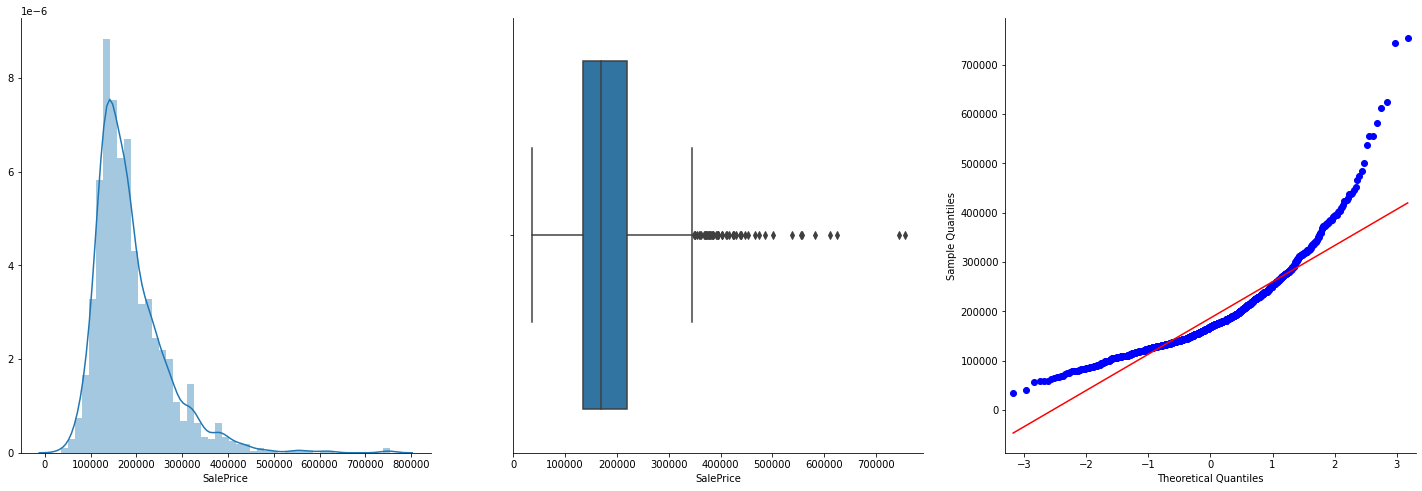

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(25, 8))
sns.despine(right = True)
sns.distplot(df1['SalePrice'], ax=axes[0])
sns.boxplot(df1['SalePrice'], ax = axes[1])
sm.qqplot(df1['SalePrice'], line = 'r', ax = axes[2]);

Target variable SalePrice does not seem normally distributed. It is right skewed with outliers on the right hand side. It's mean is greater than median.

H0: SalePrice is normally distributed.
<br>
H1: It is not.

In [7]:
loc, scale = stats.norm.fit(df1['SalePrice'])
n = stats.norm(loc=loc, scale=scale)
print("p-value of Kolmogorov-Smirnov test:",stats.kstest(df1['SalePrice'], n.cdf)[1])

p-value of Kolmogorov-Smirnov test: 1.9391520502693722e-20


H0 is rejected since p-value is less than 0.05.

In [8]:
z_score = np.abs(stats.zscore(df1['SalePrice']))
sum = 0
for i in range(len(z_score)):
    if (z_score[i] > 3):
        sum = sum+1
    else:
        continue
print("There are", sum, "outliers in SalePrice.")

There are 20 outliers in SalePrice.


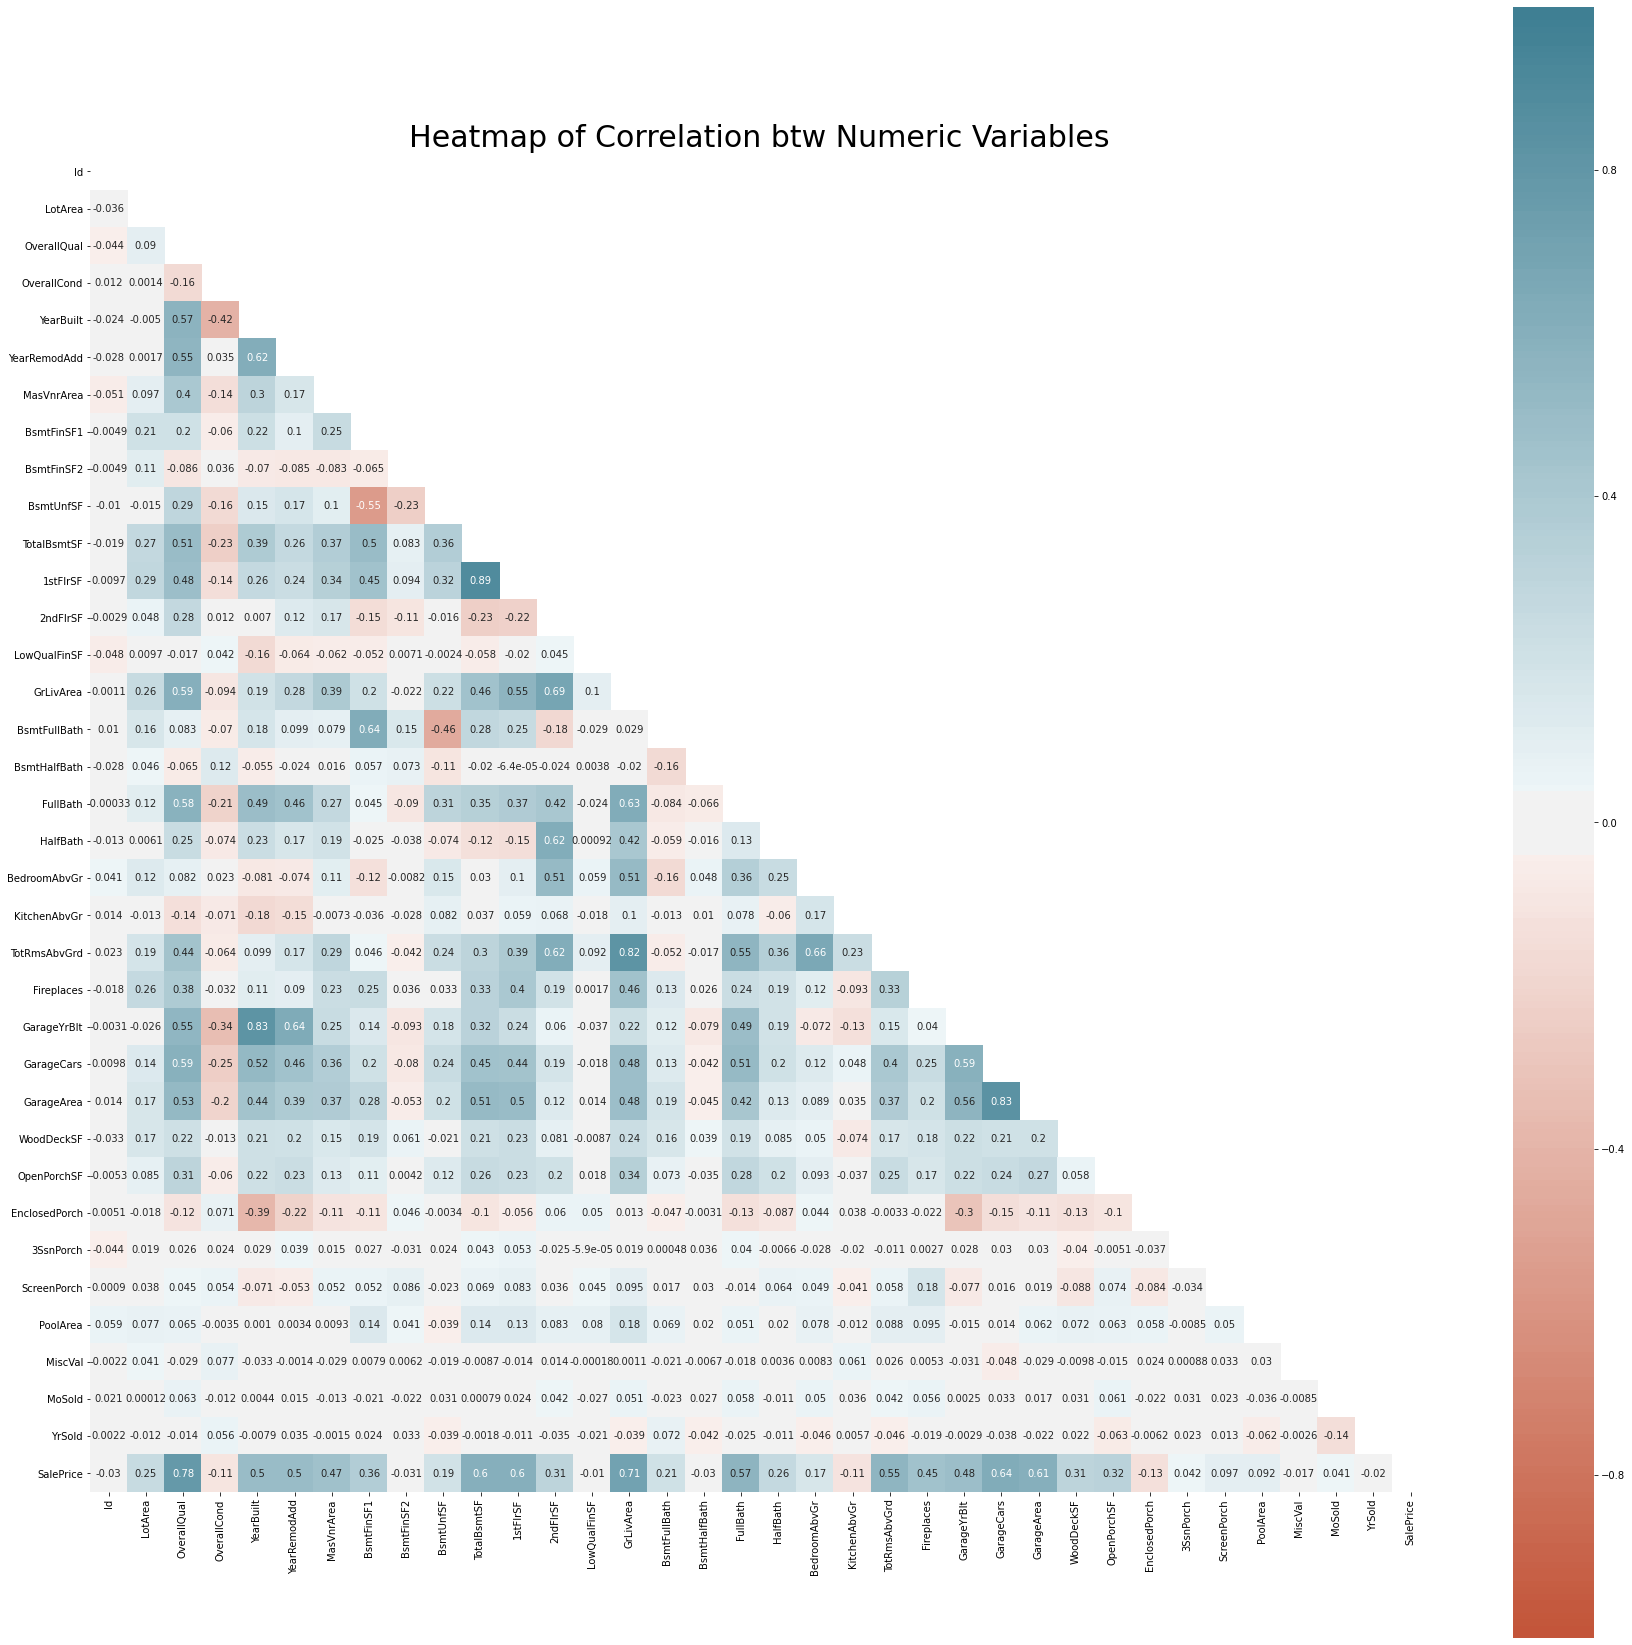

In [9]:
corr = df1.corr(method = 'pearson')
matrix = np.triu(corr)
fig = plt.subplots(figsize=(30,30))  
sns.heatmap(corr, annot = True, vmin=-1, vmax=1, center= 0, square = True,
                  cmap = sns.diverging_palette(20, 220, n=200), mask = matrix)
plt.title('Heatmap of Correlation btw Numeric Variables', fontsize = 30)
plt.show()

Heatmap is used for general knowledge only. Since some of the varaibles are ordinal Pearson correlation would not give exact results but it may give a first insight about relations.

 ## *MCAR* 

In [10]:
def create_mcar_single(df, missing_column, p_missing, random_state=709):
    np.random.seed(random_state)
    indices = [df.sample(n = 1).index[0] for i in range(round(p_missing * df.shape[0]))]
    while len(set(indices)) < round(p_missing * df.shape[0]):
        indices.append(df.sample(n = 1).index[0])
    mcar_column = [1 if i in indices else 0 for i in range(df.shape[0])]
    
    df_new = df.copy()
    for i in range(len(mcar_column)):
        if mcar_column[i] == 1:
            df_new[missing_column][i] = '?'      
    df_new = df_new.replace('?', np.nan)
    return df_new

In [11]:
def create_mcar_mult(df, mising_column, p_missing, random_state):
    df_new = df.copy()
    for i in range(len(mising_column)):
        tmp = create_mcar_single(df, mising_column[i], p_missing, random_state=random_state+i)
        df_new[mising_column[i]] = tmp[mising_column[i]] 
    return df_new

In [12]:
def create_mcar(df, missing_column, p_missing, random_state=709):
    if (type(missing_column) == str):
        df_new = create_mcar_single(df, missing_column, p_missing, random_state=709)
    elif (type(missing_column) == list):
        df_new = create_mcar_mult(df, missing_column, p_missing, random_state=709)
    else:
        raise Exception('Name of the columns should be given as either str or list. Given format was {}'.format(
            type(missing_column)))
    return df_new

In [13]:
def test_mcar_single(df, missing_column, p_missing):
    if (df[missing_column].isna().sum() == round(p_missing * df.shape[0])):
        print('Missingness created for', missing_column ,'succesfully!')
    else:
        print('Something is wrong.')

In [14]:
def test_mcar_mult(df, missing_column, p_missing):
    for i in range(len(missing_column)):
        test_mcar_single(df, missing_column[i], p_missing)

In [15]:
def test_mcar(df, missing_column, p_missing):
    if (type(missing_column) == str):
        result = test_mcar_single(df, missing_column, p_missing)
    elif (type(missing_column) == list):
        result = test_mcar_mult(df, missing_column, p_missing)
    return(result)

## *MAR* 

In [16]:
def create_mar_single(df, missing_column, p_missing, depends_on, threshold, condition):
    
    if condition == 'less':
        np.random.seed(4)
        t =  (df[depends_on] <= threshold) 
        right_indices = list(compress(range(len(t)), t))
        indices = random.choices(right_indices, k = round(p_missing*df.shape[0]))
        while len(set(indices)) < round(p_missing * df.shape[0]):
            indices.append(random.choice(right_indices))
        mar_column = [1 if i in indices else 0 for i in range(df.shape[0])]
        
    elif condition == 'greater':
        np.random.seed(5)
        indices = []
        t =  (df[depends_on] > threshold) 
        right_indices = list(compress(range(len(t)), t))
        indices = random.choices(right_indices, k = round(p_missing*df.shape[0]))
        while len(set(indices)) < round(p_missing * df.shape[0]):
            indices.append(random.choice(right_indices))
        mar_column = [1 if i in indices else 0 for i in range(df.shape[0])]
    
    else:
        raise Exception('Condition must be less or greater. Given condition was: {}'.format(condition))
    
    df_new = df.copy()
    for i in range(len(mar_column)):
        if mar_column[i] == 1:
            df_new[missing_column][i] = '?'
        
    df_new = df_new.replace('?', np.nan)
    return df_new

In [17]:
def create_mar_mult(df, missing_column, p_missing, depends_on, threshold, condition):
    df_new = df.copy()
    for i in range(len(missing_column)):
        tmp = create_mar_single(df, missing_column[i], p_missing, depends_on, threshold, condition)
        df_new[missing_column[i]] = tmp[missing_column[i]] 
    return df_new

In [18]:
def create_mar(df, missing_column, p_missing, depends_on, threshold, condition):
    if(type(missing_column) == str):
        df_new = create_mar_single(df, missing_column, p_missing, depends_on, threshold, condition)
    elif(type(missing_column) == list):
        df_new = create_mar_mult(df, missing_column, p_missing, depends_on, threshold, condition)
    else:
        raise Exception('Name of the columns should be given as either str or list. Given format was {}'.format(
            type(missing_column)))
    return df_new 

In [19]:
def test_mar_single(df, missing_column, p_missing, depends_on,threshold,condition):
    if condition == 'less':
        t = df[missing_column].isna()
        q = list(compress(range(len(t)), t)) #Which indices have NAs
        w = df[depends_on][q] > threshold #Which indices have a value greater than threshold value
        l = list(compress(range(len(w)), w)) #Indices of values greater than 5. Must be an empty set.
    
    elif condition == 'greater':
        t = df[missing_column].isna()
        q = list(compress(range(len(t)), t)) #Which indices have NAs
        w = df[depends_on][q] <= threshold #Which indices have a value less than or equal to threshold
        l = list(compress(range(len(w)), w)) #Indices of values greater than 5. Must be an empty set.
    
    else:
        raise Exception('Condition must be less or greater. Given condition was: {}'.format(condition))
    
    if len(l) == 0 and (df[missing_column].isna().sum() == round(p_missing * df.shape[0])):
        print("Missingness created for", missing_column ,"succesfully!")
    else:
        print("Something is wrong.")

In [20]:
def test_mar_mult(df, missing_column, p_missing, depends_on,threshold,condition):
    for i in range(len(missing_column)):
        test_mar_single(df, missing_column[i], p_missing, depends_on,threshold,condition)

In [21]:
def test_mar(df, missing_column, p_missing, depends_on,threshold,condition):
    if (type(missing_column) == str):
        result = test_mar_single(df, missing_column, p_missing, depends_on,threshold,condition)
    elif (type(missing_column) == list):
        result = test_mar_mult(df, missing_column, p_missing, depends_on,threshold,condition)
    return(result)

## *MNAR*

In [22]:
def create_mnar_single(df, missing_column, p_missing, threshold, condition):
    
    if condition == 'less':
        np.random.seed(3)
        t = (df[missing_column] <= threshold)
        right_indices = list(compress(range(len(t)), t))
        indices = random.choices(right_indices, k = round(p_missing*df.shape[0]))
        while len(set(indices)) < round(p_missing * df.shape[0]):
            add = random.choice(right_indices)
            indices.append(add)
        mar_column = [1 if i in indices else 0 for i in range(df.shape[0])]
    
    elif condition == 'greater':
        np.random.seed(7)
        t = (df[missing_column] > threshold)
        right_indices = list(compress(range(len(t)), t))
        indices = random.choices(right_indices, k = round(p_missing*df.shape[0]))
        while len(set(indices)) < round(p_missing * df.shape[0]):
            indices.append(random.choice(right_indices))
        mar_column = [1 if i in indices else 0 for i in range(df.shape[0])]

    else:
        raise Exception('Condition must be less or greater. Given condition was: {}'.format(condition))
    
    df_new = df.copy() 
    for i in range(len(mar_column)):
        if mar_column[i] == 1:
            df_new[missing_column][i] = '?'
        
    df_new = df_new.replace('?', np.nan)
    return df_new

In [23]:
def create_mnar_mult(df, missing_column, p_missing, threshold, condition):
    df_new = df.copy()
    for i in range(len(missing_column)):
        tmp = create_mnar_single(df, missing_column[i], p_missing, threshold[i], condition[i])
        df_new[missing_column[i]] = tmp[missing_column[i]] 
    return df_new        

In [24]:
def create_mnar(df, missing_column, p_missing, threshold, condition):
    if (type(missing_column) == str):
        df_new = create_mnar_single(df, missing_column, p_missing, threshold, condition)
    elif (type(missing_column) == list):
        df_new = create_mnar_mult(df, missing_column, p_missing, threshold, condition)
    else:
        raise Exception('Name of the columns should be given as either str or list. Given format was {}'.format(
            type(missing_column)))
        
    return df_new

In [25]:
def test_mnar_single(df, missing_column, p_missing, threshold, condition):
    if condition == 'less':
        t = df[missing_column].isna()
        q = list(compress(range(len(t)), t)) #Which indices have NAs
        w = df[missing_column][q] > threshold #Which indices have a value greater than threshold value
        l = list(compress(range(len(w)), w)) #Indices of values greater than 5. Must be an empty set.
    
    elif condition == 'greater':
        t = df[missing_column].isna()
        q = list(compress(range(len(t)), t)) #Which indices have NAs
        w = df[missing_column][q] <= threshold #Which indices have a value less than or equal to threshold
        l = list(compress(range(len(w)), w)) #Indices of values greater than 5. Must be an empty set.
    
    else:
        raise Exception('Condition must be less or greater. Given condition was: {}'.format(condition))
    
    if len(l) == 0 and (df[missing_column].isna().sum() == round(p_missing * df.shape[0])):
        print("Missingness created for", missing_column, "succesfully!")
    else:
        print("Something is wrong.")

In [26]:
def test_mnar_mult(df, missing_column, p_missing, threshold, condition):
    for i in range(len(missing_column)):
        test_mnar_single(df, missing_column[i], p_missing, threshold[i], condition[i])

In [27]:
def test_mnar(df, missing_column, p_missing, threshold, condition):
    if (type(missing_column) == str):
        test_mnar_single(df, missing_column, p_missing, threshold, condition)
    elif (type(missing_column) == list):
        test_mnar_mult(df, missing_column, p_missing, threshold, condition)

## Question 2

### 2.a

In [28]:
df_2a1 = create_mcar(df1,'OverallQual', 0.05)
test_mcar(df_2a1, 'OverallQual', 0.05)
#df_2a1.to_csv(r'C:\Users\Test\Desktop\Courses\IS709\Project\df_2a1.csv', index = False, header = True)

Missingness created for OverallQual succesfully!


In [29]:
df_2a2 = create_mcar(df1,'OverallQual', 0.10)
test_mcar(df_2a2, 'OverallQual', 0.10)
#df_2a2.to_csv(r'C:\Users\Test\Desktop\Courses\IS709\Project\df_2a2.csv', index = False, header = True)

Missingness created for OverallQual succesfully!


In [30]:
df_2a3 = create_mcar(df1,'OverallQual', 0.25)
test_mcar(df_2a3, 'OverallQual', 0.25)
#df_2a3.to_csv(r'C:\Users\Test\Desktop\Courses\IS709\Project\df_2a3.csv', index = False, header = True)

Missingness created for OverallQual succesfully!


In [31]:
df_2a4 = create_mcar(df1,'OverallQual', 0.50)
test_mcar(df_2a4, 'OverallQual', 0.50)
#df_2a4.to_csv(r'C:\Users\Test\Desktop\Courses\IS709\Project\df_2a4.csv', index = False, header = True)

Missingness created for OverallQual succesfully!


### 2.b

OverallCond variable is used as missingness created in OverallQual. Since if overall condition of a house is low overall quality is low too. They have a correlation

In [32]:
stats.spearmanr(df1['OverallQual'],df1['YearBuilt'])

SpearmanrResult(correlation=0.6508374831750432, pvalue=4.942834036594504e-162)

In [33]:
CSS = """
div.cell:nth-child(45) .output {
    flex-direction: row;
}
"""
HTML('<style>{}</style>'.format(CSS))

count    1338.000000
mean     1973.029148
std        29.563540
min      1880.000000
25%      1956.000000
50%      1976.000000
75%      2001.000000
max      2010.000000
Name: YearBuilt, dtype: float64

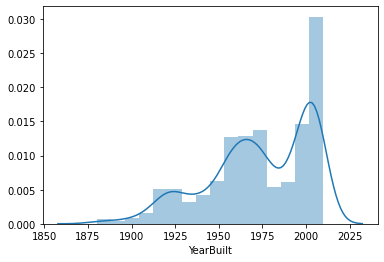

In [34]:
sns.distplot(df1['YearBuilt'])
df1["YearBuilt"].describe() 

Correlation between OverallQual and YearBuilt is 0.65  means as the year built is increased, age of the building decrease, overall quality increases too. There is a positive relation. It can be used to create MAR. YearBuilt is left-skewed. For creating 5% missingness 5th quantile, for 10% 10th quantile, for 25% first quartile and for 50% median can be used. 

In [35]:
df_2b1 = create_mar(df1, 'OverallQual', 0.05, 'YearBuilt', df1["YearBuilt"].quantile(0.05), 'less')
test_mar(df_2b1, 'OverallQual', 0.05, 'YearBuilt', df1["YearBuilt"].quantile(0.05), 'less')
#df_2b1.to_csv(r'C:\Users\Test\Desktop\Courses\IS709\Project\df_2b1.csv', index = False, header = True)

Missingness created for OverallQual succesfully!


In [36]:
df_2b2 = create_mar(df1, 'OverallQual', 0.10, 'YearBuilt', df1["YearBuilt"].quantile(0.10), 'less')
test_mar(df_2b2, 'OverallQual', 0.10, 'YearBuilt', df1["YearBuilt"].quantile(0.10), 'less')
#df_2b2.to_csv(r'C:\Users\Test\Desktop\Courses\IS709\Project\df_2b2.csv', index = False, header = True)

Missingness created for OverallQual succesfully!


In [37]:
df_2b3 = create_mar(df1, 'OverallQual', 0.25, 'YearBuilt', 1956, 'less')
test_mar(df_2b3, 'OverallQual', 0.25, 'YearBuilt', 1956, 'less')
#df_2b3.to_csv(r'C:\Users\Test\Desktop\Courses\IS709\Project\df_2b3.csv', index = False, header = True)

Missingness created for OverallQual succesfully!


In [38]:
df_2b4 = create_mar(df1, 'OverallQual', 0.50, 'YearBuilt', 1976, 'less')
test_mar(df_2b4, 'OverallQual', 0.50, 'YearBuilt', 1976, 'less')
#df_2b4.to_csv(r'C:\Users\Test\Desktop\Courses\IS709\Project\df_2b4.csv', index = False, header = True)

Missingness created for OverallQual succesfully!


## 2.c

In [39]:
CSS = """
div.cell:nth-child(53) .output {
    flex-direction: row;
}
"""
HTML('<style>{}</style>'.format(CSS))

col_0,count
OverallQual,
2,2
3,8
4,81
5,351
6,359
7,312
8,165
9,43
10,17


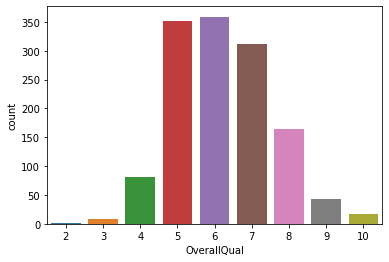

In [40]:
sns.countplot(df1['OverallQual'])
freq_tab = pd.crosstab(index=df1["OverallQual"], columns="count")     
freq_tab

In [41]:
df1.OverallQual.describe()

count    1338.000000
mean        6.219731
std         1.324472
min         2.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: OverallQual, dtype: float64

To create MNAR with 5% and 10% missingness 1st quartile, for 25% missingness median and for 50% missingness 3rd quartile can be used.

In [42]:
df_2c1 = create_mnar(df1, 'OverallQual', 0.05, 5, 'less')
test_mnar(df_2c1, 'OverallQual', 0.05, 5, 'less')
#df_2c1.to_csv(r'C:\Users\Test\Desktop\Courses\IS709\Project\df_2c1.csv', index = False, header = True)

Missingness created for OverallQual succesfully!


In [43]:
df_2c2 = create_mnar(df1, 'OverallQual', 0.10, 5, 'less')
test_mnar(df_2c2, 'OverallQual', 0.10, 5, 'less')
#df_2c2.to_csv(r'C:\Users\Test\Desktop\Courses\IS709\Project\df_2c2.csv', index = False, header = True)#

Missingness created for OverallQual succesfully!


In [44]:
df_2c3 = create_mnar(df1, 'OverallQual', 0.25, 6, 'less')
test_mnar(df_2c3, 'OverallQual', 0.25, 6, 'less')
#df_2c3.to_csv(r'C:\Users\Test\Desktop\Courses\IS709\Project\df_2c3.csv', index = False, header = True)#

Missingness created for OverallQual succesfully!


In [45]:
df_2c4 = create_mnar(df1, 'OverallQual', 0.50, 7, 'less')
test_mnar(df_2c4, 'OverallQual', 0.50, 7, 'less')
#df_2c4.to_csv(r'C:\Users\Test\Desktop\Courses\IS709\Project\df_2c4.csv', index = False, header = True)

Missingness created for OverallQual succesfully!


## 3.a

In [46]:
df_3a1 = create_mcar(df1, ['OverallQual','YearBuilt','1stFlrSF','GarageYrBlt','GarageArea'], 0.05)
test_mcar(df_3a1, ['OverallQual','YearBuilt','1stFlrSF','GarageYrBlt','GarageArea'], 0.05)
#df_3a1.to_csv(r'C:\Users\Test\Desktop\Courses\IS709\Project\df_3a1.csv', index = False, header = True)

Missingness created for OverallQual succesfully!
Missingness created for YearBuilt succesfully!
Missingness created for 1stFlrSF succesfully!
Missingness created for GarageYrBlt succesfully!
Missingness created for GarageArea succesfully!


In [47]:
df_3a2 = create_mcar(df1, ['OverallQual','YearBuilt','1stFlrSF','GarageYrBlt','GarageArea'], 0.10)
test_mcar(df_3a2, ['OverallQual','YearBuilt','1stFlrSF','GarageYrBlt','GarageArea'], 0.10)
#df_3a2.to_csv(r'C:\Users\Test\Desktop\Courses\IS709\Project\df_3a2.csv', index = False, header = True)

Missingness created for OverallQual succesfully!
Missingness created for YearBuilt succesfully!
Missingness created for 1stFlrSF succesfully!
Missingness created for GarageYrBlt succesfully!
Missingness created for GarageArea succesfully!


In [48]:
df_3a3 = create_mcar(df1, ['OverallQual','YearBuilt','1stFlrSF','GarageYrBlt','GarageArea'], 0.25)
test_mcar(df_3a3, ['OverallQual','YearBuilt','1stFlrSF','GarageYrBlt','GarageArea'], 0.25)
#df_3a3.to_csv(r'C:\Users\Test\Desktop\Courses\IS709\Project\df_3a3.csv', index = False, header = True)

Missingness created for OverallQual succesfully!
Missingness created for YearBuilt succesfully!
Missingness created for 1stFlrSF succesfully!
Missingness created for GarageYrBlt succesfully!
Missingness created for GarageArea succesfully!


In [49]:
df_3a4 = create_mcar(df1, ['OverallQual','YearBuilt','1stFlrSF','GarageYrBlt','GarageArea'], 0.50)
test_mcar(df_3a4, ['OverallQual','YearBuilt','1stFlrSF','GarageYrBlt','GarageArea'], 0.50)
#df_3a4.to_csv(r'C:\Users\Test\Desktop\Courses\IS709\Project\df_3a4.csv', index = False, header = True)

Missingness created for OverallQual succesfully!
Missingness created for YearBuilt succesfully!
Missingness created for 1stFlrSF succesfully!
Missingness created for GarageYrBlt succesfully!
Missingness created for GarageArea succesfully!


## 3.b

In [50]:
print("Correlation between",
        "\nOverallQual and SalePrice:  ", "%.5f" %(stats.spearmanr(df1['OverallQual'], df1['SalePrice']))[0],
        "\nYearBuilt and SalePrice:    ", "%.5f" %(stats.spearmanr(df1['YearBuilt'], df1['SalePrice']))[0],
        "\n1stFlrSF and SalePrice:     ", "%.5f" %(stats.pearsonr(df1['1stFlrSF'], df1['SalePrice']))[0],
        "\nGarageYrBlt and SalePrice:  ", "%.5f" %(stats.spearmanr(df1['GarageYrBlt'], df1['SalePrice']))[0],
        "\nGarageArea and SalePrice:   ", "%.5f" %(stats.pearsonr(df1['GarageArea'], df1['SalePrice']))[0])

Correlation between 
OverallQual and SalePrice:   0.80303 
YearBuilt and SalePrice:     0.64356 
1stFlrSF and SalePrice:      0.60471 
GarageYrBlt and SalePrice:   0.58860 
GarageArea and SalePrice:    0.60754


OverallQual, YearBuilt, 1stFlrSF, GarageYrBlt, GarageArea are positively correlated with SalePrice. Again with same rule 1st quartile of SalePrice for 5% and 10%, median of SalePrice for 25% and 3rd quartile of SalePrice for 50% missingness in other variables.

In [51]:
df_3b1 = create_mar(df1,['OverallQual','YearBuilt','1stFlrSF','GarageYrBlt','GarageArea'], 0.05, 'SalePrice', 
                    np.quantile(df1['SalePrice'],0.05), 'less')
test_mar(df_3b1,['OverallQual','YearBuilt','1stFlrSF','GarageYrBlt','GarageArea'], 0.05, 'SalePrice',         
         np.quantile(df1['SalePrice'],0.05), 'less')
#df_3b1.to_csv(r'C:\Users\Test\Desktop\Courses\IS709\Project\df_3b1.csv', index = False, header = True)

Missingness created for OverallQual succesfully!
Missingness created for YearBuilt succesfully!
Missingness created for 1stFlrSF succesfully!
Missingness created for GarageYrBlt succesfully!
Missingness created for GarageArea succesfully!


In [52]:
df_3b2 = create_mar(df1,['OverallQual','YearBuilt','1stFlrSF','GarageYrBlt','GarageArea'], 0.10, 'SalePrice', 
                    np.quantile(df1['SalePrice'],0.10), 'less')
test_mar(df_3b2,['OverallQual','YearBuilt','1stFlrSF','GarageYrBlt','GarageArea'], 0.10, 'SalePrice',         
         np.quantile(df1['SalePrice'],0.10), 'less')
#df_3b2.to_csv(r'C:\Users\Test\Desktop\Courses\IS709\Project\df_3b2.csv', index = False, header = True)

Missingness created for OverallQual succesfully!
Missingness created for YearBuilt succesfully!
Missingness created for 1stFlrSF succesfully!
Missingness created for GarageYrBlt succesfully!
Missingness created for GarageArea succesfully!


In [53]:
df_3b3 = create_mar(df1,['OverallQual','YearBuilt','1stFlrSF','GarageYrBlt','GarageArea'], 0.25, 'SalePrice', 
                    np.quantile(df1['SalePrice'],0.25), 'less')
test_mar(df_3b3,['OverallQual','YearBuilt','1stFlrSF','GarageYrBlt','GarageArea'], 0.25, 'SalePrice',         
         np.quantile(df1['SalePrice'],0.25), 'less')
#df_3b3.to_csv(r'C:\Users\Test\Desktop\Courses\IS709\Project\df_3b3.csv', index = False, header = True)

Missingness created for OverallQual succesfully!
Missingness created for YearBuilt succesfully!
Missingness created for 1stFlrSF succesfully!
Missingness created for GarageYrBlt succesfully!
Missingness created for GarageArea succesfully!


In [54]:
df_3b4 = create_mar(df1,['OverallQual','YearBuilt','1stFlrSF','GarageYrBlt','GarageArea'], 0.50, 'SalePrice', 
                    np.quantile(df1['SalePrice'],0.5), 'less')
test_mar(df_3b4,['OverallQual','YearBuilt','1stFlrSF','GarageYrBlt','GarageArea'], 0.50, 'SalePrice',         
         np.quantile(df1['SalePrice'],0.5), 'less')
#df_3b4.to_csv(r'C:\Users\Test\Desktop\Courses\IS709\Project\df_3b4.csv', index = False, header = True)

Missingness created for OverallQual succesfully!
Missingness created for YearBuilt succesfully!
Missingness created for 1stFlrSF succesfully!
Missingness created for GarageYrBlt succesfully!
Missingness created for GarageArea succesfully!


## 3.c

In [55]:
CSS = """
div.cell:nth-child(74) .output {
    flex-direction: row;
}
"""
HTML('<style>{}</style>'.format(CSS))

count    1338.000000
mean     1176.221973
std       386.644986
min       438.000000
25%       894.000000
50%      1098.000000
75%      1414.000000
max      4692.000000
Name: 1stFlrSF, dtype: float64

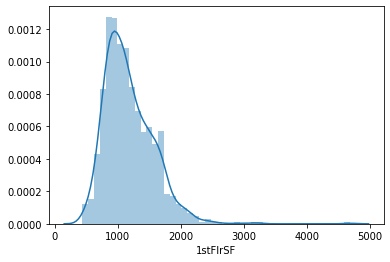

In [56]:
sns.distplot(df1['1stFlrSF'])
df1['1stFlrSF'].describe()

In [57]:
CSS = """
div.cell:nth-child(76) .output {
    flex-direction: row;
}
"""
HTML('<style>{}</style>'.format(CSS))

count    1338.000000
mean     1978.596413
std        24.773741
min      1900.000000
25%      1962.000000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64

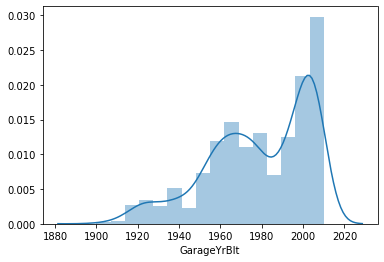

In [58]:
sns.distplot(df1['GarageYrBlt'])
df1['GarageYrBlt'].describe()

In [59]:
CSS = """
div.cell:nth-child(78) .output {
    flex-direction: row;
}
"""
HTML('<style>{}</style>'.format(CSS))

count    1338.000000
mean      501.449925
std       186.761863
min       160.000000
25%       377.500000
50%       484.000000
75%       583.000000
max      1418.000000
Name: GarageArea, dtype: float64

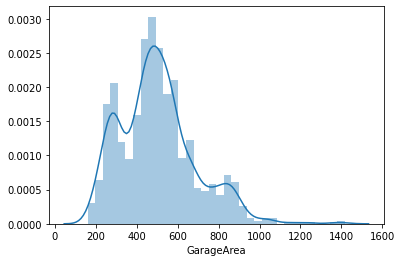

In [60]:
sns.distplot(df1['GarageArea'])
df1['GarageArea'].describe()

All variables are positively correlated with price so, as the price goes down they go down as well. Therefore I used less condition in all of them and same rule with previous ones. For example if a house has a small garage area then its price will be low. So, people may tend to not give this information to be able to give higher price than its actual value. 

In [61]:
df_3c1 = create_mnar(df1,['OverallQual','YearBuilt','1stFlrSF','GarageYrBlt','GarageArea'], 0.05,
                     [np.quantile(df1['OverallQual'],0.25),np.quantile(df1['YearBuilt'],0.25),
                      np.quantile(df1['1stFlrSF'],0.25),np.quantile(df1['GarageYrBlt'],0.25),
                      np.quantile(df1['GarageArea'],0.25)], ['less','less','less','less','less'])
test_mnar(df_3c1,['OverallQual','YearBuilt','1stFlrSF','GarageYrBlt','GarageArea'], 0.05,
          [np.quantile(df1['OverallQual'],0.25),np.quantile(df1['YearBuilt'],0.25),np.quantile(df1['1stFlrSF'],0.25),
           np.quantile(df1['GarageYrBlt'],0.25),np.quantile(df1['GarageArea'],0.25)], ['less','less','less','less','less'])
#df_3c1.to_csv(r'C:\Users\Test\Desktop\Courses\IS709\Project\df_3c1.csv', index = False, header = True)

Missingness created for OverallQual succesfully!
Missingness created for YearBuilt succesfully!
Missingness created for 1stFlrSF succesfully!
Missingness created for GarageYrBlt succesfully!
Missingness created for GarageArea succesfully!


In [62]:
df_3c2 = create_mnar(df1,['OverallQual','YearBuilt','1stFlrSF','GarageYrBlt','GarageArea'], 0.10,
                     [np.quantile(df1['OverallQual'],0.25),np.quantile(df1['YearBuilt'],0.25),
                      np.quantile(df1['1stFlrSF'],0.25),np.quantile(df1['GarageYrBlt'],0.25),
                      np.quantile(df1['GarageArea'],0.25)], ['less','less','less','less','less'])
test_mnar(df_3c2,['OverallQual','YearBuilt','1stFlrSF','GarageYrBlt','GarageArea'], 0.10,
          [np.quantile(df1['OverallQual'],0.25),np.quantile(df1['YearBuilt'],0.25),np.quantile(df1['1stFlrSF'],0.25),
           np.quantile(df1['GarageYrBlt'],0.25),np.quantile(df1['GarageArea'],0.25)], ['less','less','less','less','less'])
#df_3c2.to_csv(r'C:\Users\Test\Desktop\Courses\IS709\Project\df_3c2.csv', index = False, header = True)

Missingness created for OverallQual succesfully!
Missingness created for YearBuilt succesfully!
Missingness created for 1stFlrSF succesfully!
Missingness created for GarageYrBlt succesfully!
Missingness created for GarageArea succesfully!


In [63]:
df_3c3 = create_mnar(df1,['OverallQual','YearBuilt','1stFlrSF','GarageYrBlt','GarageArea'], 0.25,
                     [np.quantile(df1['OverallQual'],0.50),np.quantile(df1['YearBuilt'],0.50),
                      np.quantile(df1['1stFlrSF'],0.50),np.quantile(df1['GarageYrBlt'],0.50),
                      np.quantile(df1['GarageArea'],0.50)], ['less','less','less','less','less'])
test_mnar(df_3c3,['OverallQual','YearBuilt','1stFlrSF','GarageYrBlt','GarageArea'], 0.25,
          [np.quantile(df1['OverallQual'],0.50),np.quantile(df1['YearBuilt'],0.50),np.quantile(df1['1stFlrSF'],0.50),
           np.quantile(df1['GarageYrBlt'],0.50),np.quantile(df1['GarageArea'],0.50)], ['less','less','less','less','less'])
#df_3c3.to_csv(r'C:\Users\Test\Desktop\Courses\IS709\Project\df_3c3.csv', index = False, header = True)

Missingness created for OverallQual succesfully!
Missingness created for YearBuilt succesfully!
Missingness created for 1stFlrSF succesfully!
Missingness created for GarageYrBlt succesfully!
Missingness created for GarageArea succesfully!


In [64]:
df_3c4 = create_mnar(df1,['OverallQual','YearBuilt','1stFlrSF','GarageYrBlt','GarageArea'], 0.50,
                     [np.quantile(df1['OverallQual'],0.75),np.quantile(df1['YearBuilt'],0.75),
                      np.quantile(df1['1stFlrSF'],0.75),np.quantile(df1['GarageYrBlt'],0.75),
                      np.quantile(df1['GarageArea'],0.75)], ['less','less','less','less','less'])
test_mnar(df_3c4,['OverallQual','YearBuilt','1stFlrSF','GarageYrBlt','GarageArea'], 0.50,
          [np.quantile(df1['OverallQual'],0.75),np.quantile(df1['YearBuilt'],0.75),np.quantile(df1['1stFlrSF'],0.75),
           np.quantile(df1['GarageYrBlt'],0.75),np.quantile(df1['GarageArea'],0.75)], ['less','less','less','less','less'])
#df_3c4.to_csv(r'C:\Users\Test\Desktop\Courses\IS709\Project\df_3c4.csv', index = False, header = True)

Missingness created for OverallQual succesfully!
Missingness created for YearBuilt succesfully!
Missingness created for 1stFlrSF succesfully!
Missingness created for GarageYrBlt succesfully!
Missingness created for GarageArea succesfully!


## 4.a

### i.

In [65]:
def encoder_rl(df):
    col_names = df.columns
    types = df.dtypes
    a = df.columns[range(0,74)]
    b = ['x' + str(i) for i in np.arange(1,len(a)+1)]
    d = dict(zip(a, b))
    d['SalePrice'] = 'y'
    df = df.rename(columns=d)
    s = (df.dtypes == 'object')
    cat_cols = list(s[s].index)
    df = df.dropna()
    enc = LabelEncoder()
    for col in cat_cols:
        df[col] = enc.fit_transform(df[col])
    df.columns = col_names
    df = df.astype(types)
    return df

In [66]:
df_2a1_rl = encoder_rl(df_2a1)
df_2a2_rl = encoder_rl(df_2a2)
df_2a3_rl = encoder_rl(df_2a3)
df_2a4_rl = encoder_rl(df_2a4)

df_2b1_rl = encoder_rl(df_2b1)
df_2b2_rl = encoder_rl(df_2b2)
df_2b3_rl = encoder_rl(df_2b3)
df_2b4_rl = encoder_rl(df_2b4)

df_2c1_rl = encoder_rl(df_2c1)
df_2c2_rl = encoder_rl(df_2c2)
df_2c3_rl = encoder_rl(df_2c3)
df_2c4_rl = encoder_rl(df_2c4)

##############################

df_3a1_rl = encoder_rl(df_3a1)
df_3a2_rl = encoder_rl(df_3a2)
df_3a3_rl = encoder_rl(df_3a3)
df_3a4_rl = encoder_rl(df_3a4)

df_3b1_rl = encoder_rl(df_3b1)
df_3b2_rl = encoder_rl(df_3b2)
df_3b3_rl = encoder_rl(df_3b3)
df_3b4_rl = encoder_rl(df_3b4)

df_3c1_rl = encoder_rl(df_3c1)
df_3c2_rl = encoder_rl(df_3c2)
df_3c3_rl = encoder_rl(df_3c3)
df_3c4_rl = encoder_rl(df_3c4)

### ii.

In [67]:
def encoder_delf(df):
    df = df.dropna(axis=1)
    col_names = df.columns
    types = df.dtypes
    a = df.columns[range(0,len(col_names))]
    b = ['x' + str(i) for i in np.arange(1,len(a)+1)]
    d = dict(zip(a, b))
    d['SalePrice'] = 'y'
    df = df.rename(columns=d)
    df = df.dropna(axis=1)
    s = (df.dtypes == 'object')
    cat_cols = list(s[s].index)
    enc = LabelEncoder()
    for col in cat_cols:
        df[col] = enc.fit_transform(df[col])
    df.columns = col_names
    df = df.astype(types)
    return df

In [68]:
df_2_delf = encoder_delf(df_2a1)
df_3_delf = encoder_delf(df_3a1)

## 4.b

In [69]:
def single_imputer(df):
    col_names = df.columns
    types = df.dtypes.to_dict()
    a = df.columns[range(0,74)]
    b = ['x' + str(i) for i in np.arange(1,len(a)+1)]
    d = dict(zip(a, b))
    d['SalePrice'] = 'y'
    df = df.rename(columns=d)
    s = (df.dtypes == 'object')
    cat_cols = list(s[s].index)
    enc = LabelEncoder()
    for col in cat_cols:
        df[col] = enc.fit_transform(df[col])
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp.fit(df)
    df_imputed = pd.DataFrame(imp.transform(df))
    df_imputed.columns = col_names
    df_imputed = df_imputed.astype(types)
    return df_imputed

In [70]:
df_2a1_si = single_imputer(df_2a1)
df_2a2_si = single_imputer(df_2a2)
df_2a3_si = single_imputer(df_2a3)
df_2a4_si = single_imputer(df_2a4)

df_2b1_si = single_imputer(df_2b1)
df_2b2_si = single_imputer(df_2b2)
df_2b3_si = single_imputer(df_2b3)
df_2b4_si = single_imputer(df_2b4)

df_2c1_si = single_imputer(df_2c1)
df_2c2_si = single_imputer(df_2c2)
df_2c3_si = single_imputer(df_2c3)
df_2c4_si = single_imputer(df_2c4)

##################################

df_3a1_si = single_imputer(df_3a1)
df_3a2_si = single_imputer(df_3a2)
df_3a3_si = single_imputer(df_3a3)
df_3a4_si = single_imputer(df_3a4)

df_3b1_si = single_imputer(df_3b1)
df_3b2_si = single_imputer(df_3b2)
df_3b3_si = single_imputer(df_3b3)
df_3b4_si = single_imputer(df_3b4)

df_3c1_si = single_imputer(df_3c1)
df_3c2_si = single_imputer(df_3c2)
df_3c3_si = single_imputer(df_3c3)
df_3c4_si = single_imputer(df_3c4)

## 4.c

In [71]:
def multiple_imputer(df,n):
    col_names = df.columns
    types = df.dtypes.to_dict()
    a = df.columns[range(0,74)]
    b = ['x' + str(i) for i in np.arange(1,len(a)+1)]
    d = dict(zip(a, b))
    d['SalePrice'] = 'y'
    df = df.rename(columns=d)
    s = (df.dtypes == 'object')
    cat_cols = list(s[s].index)
    enc = LabelEncoder()
    for col in cat_cols:
        df[col] = enc.fit_transform(df[col])
    mice_dfs = []
    imp = mice.MICEData(df)
    imp.set_imputer('x16, x18, x42, x57, x60', formula='x16 + x18 + x42 + x57 + x60')
    for j in range(n):
        imp.update_all()
        mice_dfs.append(pd.DataFrame(imp.data))
    for i in range(len(mice_dfs)):
        mice_dfs[i].columns = col_names
        mice_dfs[i] = mice_dfs[i].astype(types)
    return mice_dfs

### i.

In [72]:
df_2a1_mi1 = multiple_imputer(df_2a1,10) 
df_2a2_mi1 = multiple_imputer(df_2a2,10)
df_2a3_mi1 = multiple_imputer(df_2a3,10)
df_2a4_mi1 = multiple_imputer(df_2a4,10)

df_2b1_mi1 = multiple_imputer(df_2b1,10)
df_2b2_mi1 = multiple_imputer(df_2b2,10)
df_2b3_mi1 = multiple_imputer(df_2b3,10)
df_2b4_mi1 = multiple_imputer(df_2b4,10)

df_2c1_mi1 = multiple_imputer(df_2c1,10)
df_2c2_mi1 = multiple_imputer(df_2c2,10)
df_2c3_mi1 = multiple_imputer(df_2c3,10)
df_2c4_mi1 = multiple_imputer(df_2c4,10)

########################################

df_3a1_mi1 = multiple_imputer(df_3a1,10)
df_3a2_mi1 = multiple_imputer(df_3a2,10)
df_3a3_mi1 = multiple_imputer(df_3a3,10)
df_3a4_mi1 = multiple_imputer(df_3a4,10)

df_3b1_mi1 = multiple_imputer(df_3b1,10)
df_3b2_mi1 = multiple_imputer(df_3b2,10)
df_3b3_mi1 = multiple_imputer(df_3b3,10)
df_3b4_mi1 = multiple_imputer(df_3b4,10)

df_3c1_mi1 = multiple_imputer(df_3c1,10)
df_3c2_mi1 = multiple_imputer(df_3c2,10)
df_3c3_mi1 = multiple_imputer(df_3c3,10)
df_3c4_mi1 = multiple_imputer(df_3c4,10)

### ii.

In [73]:
df_2a1_mi2 = multiple_imputer(df_2a1,20)
df_2a2_mi2 = multiple_imputer(df_2a2,20)
df_2a3_mi2 = multiple_imputer(df_2a3,20)
df_2a4_mi2 = multiple_imputer(df_2a4,20)

df_2b1_mi2 = multiple_imputer(df_2b1,20)
df_2b2_mi2 = multiple_imputer(df_2b2,20)
df_2b3_mi2 = multiple_imputer(df_2b3,20)
df_2b4_mi2 = multiple_imputer(df_2b4,20)

df_2c1_mi2 = multiple_imputer(df_2c1,20)
df_2c2_mi2 = multiple_imputer(df_2c2,20)
df_2c3_mi2 = multiple_imputer(df_2c3,20)
df_2c4_mi2 = multiple_imputer(df_2c4,20)

########################################

df_3a1_mi2 = multiple_imputer(df_3a1,20)
df_3a2_mi2 = multiple_imputer(df_3a2,20)
df_3a3_mi2 = multiple_imputer(df_3a3,20)
df_3a4_mi2 = multiple_imputer(df_3a4,20)

df_3b1_mi2 = multiple_imputer(df_3b1,20)
df_3b2_mi2 = multiple_imputer(df_3b2,20)
df_3b3_mi2 = multiple_imputer(df_3b3,20)
df_3b4_mi2 = multiple_imputer(df_3b4,20)

df_3c1_mi2 = multiple_imputer(df_3c1,20)
df_3c2_mi2 = multiple_imputer(df_3c2,20)
df_3c3_mi2 = multiple_imputer(df_3c3,20)
df_3c4_mi2 = multiple_imputer(df_3c4,20)

### iii.

In [74]:
df_2a1_mi3 = multiple_imputer(df_2a1,30)
df_2a2_mi3 = multiple_imputer(df_2a2,30)
df_2a3_mi3 = multiple_imputer(df_2a3,30)
df_2a4_mi3 = multiple_imputer(df_2a4,30)

df_2b1_mi3 = multiple_imputer(df_2b1,30)
df_2b2_mi3 = multiple_imputer(df_2b2,30)
df_2b3_mi3 = multiple_imputer(df_2b3,30)
df_2b4_mi3 = multiple_imputer(df_2b4,30)

df_2c1_mi3 = multiple_imputer(df_2c1,30)
df_2c2_mi3 = multiple_imputer(df_2c2,30)
df_2c3_mi3 = multiple_imputer(df_2c3,30)
df_2c4_mi3 = multiple_imputer(df_2c4,30)

########################################

df_3a1_mi3 = multiple_imputer(df_3a1,30)
df_3a2_mi3 = multiple_imputer(df_3a2,30)
df_3a3_mi3 = multiple_imputer(df_3a3,30)
df_3a4_mi3 = multiple_imputer(df_3a4,30)

df_3b1_mi3 = multiple_imputer(df_3b1,30)
df_3b2_mi3 = multiple_imputer(df_3b2,30)
df_3b3_mi3 = multiple_imputer(df_3b3,30)
df_3b4_mi3 = multiple_imputer(df_3b4,30)

df_3c1_mi3 = multiple_imputer(df_3c1,30)
df_3c2_mi3 = multiple_imputer(df_3c2,30)
df_3c3_mi3 = multiple_imputer(df_3c3,30)
df_3c4_mi3 = multiple_imputer(df_3c4,30)

## 5

In [75]:
def KNN_imputer(df):
    col_names = df.columns
    types = df.dtypes.to_dict()
    a = df.columns[range(0,74)]
    b = ['x' + str(i) for i in np.arange(1,len(a)+1)]
    d = dict(zip(a, b))
    d['SalePrice'] = 'y'
    df = df.rename(columns=d)
    s = (df.dtypes == 'object')
    cat_cols = list(s[s].index)
    enc = LabelEncoder()
    for col in cat_cols:
        df[col] = enc.fit_transform(df[col])
    imp = KNNImputer()
    df_imputed = pd.DataFrame(imp.fit_transform(df))
    df_imputed.columns = col_names
    df_imputed = df_imputed.astype(types)
    return df_imputed

In [76]:
df_2a1_pm = KNN_imputer(df_2a1)
df_2a2_pm = KNN_imputer(df_2a2)
df_2a3_pm = KNN_imputer(df_2a3)
df_2a4_pm = KNN_imputer(df_2a4)

df_2b1_pm = KNN_imputer(df_2b1)
df_2b2_pm = KNN_imputer(df_2b2)
df_2b3_pm = KNN_imputer(df_2b3)
df_2b4_pm = KNN_imputer(df_2b4)

df_2c1_pm = KNN_imputer(df_2c1)
df_2c2_pm = KNN_imputer(df_2c2)
df_2c3_pm = KNN_imputer(df_2c3)
df_2c4_pm = KNN_imputer(df_2c4)

###############################

df_3a1_pm = KNN_imputer(df_3a1)
df_3a2_pm = KNN_imputer(df_3a2)
df_3a3_pm = KNN_imputer(df_3a3)
df_3a4_pm = KNN_imputer(df_3a4)

df_3b1_pm = KNN_imputer(df_3b1)
df_3b2_pm = KNN_imputer(df_3b2)
df_3b3_pm = KNN_imputer(df_3b3)
df_3b4_pm = KNN_imputer(df_3b4)

df_3c1_pm = KNN_imputer(df_3c1)
df_3c2_pm = KNN_imputer(df_3c2)
df_3c3_pm = KNN_imputer(df_3c3)
df_3c4_pm = KNN_imputer(df_3c4)

In [77]:
def regression_single(df):
    df['ConstructionAge'] = 2020 - df['YearBuilt']       #
    df['ModeledAge'] = 2020 - df['YearRemodAdd']
    df['GarageAge'] = 2020 - df['GarageYrBlt']           # COMMENT THESE LINES BEFORE df_3_delf
    df = df.drop(columns = 'YearBuilt')                  #
    df = df.drop(columns = 'YearRemodAdd')
    df = df.drop(columns = 'GarageYrBlt')                #
    col_names = df.columns
    a = df.columns[range(0,len(df.columns))]
    b = ['x' + str(i) for i in np.arange(1,len(a)+1)]
    d = dict(zip(a, b))
    d['SalePrice'] = 'y'
    df = df.rename(columns=d)
    s = (df.dtypes == 'object')
    cat_cols = list(s[s].index)
    n = (df.dtypes != 'object')
    num_cols = list(n[n].index)
    #Onehot encoder
    OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)   
    OH_cat_cols = pd.DataFrame(OH_encoder.fit_transform(df[cat_cols]))
    OH_cat_cols.columns = OH_encoder.get_feature_names(cat_cols)
    #Numeric variables
    scaler = StandardScaler() 
    scaled_num_cols = pd.DataFrame(scaler.fit_transform(df[num_cols]))
    scaled_num_cols.columns = num_cols
    df_new = pd.concat([scaled_num_cols, OH_cat_cols], axis=1)
    #Train-test split
    y = df_new['y']
    X = df_new.drop(['y'],1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=709)
    #Select best features
    selector = SelectKBest(f_regression, k=50)
    selector.fit(X_train,y_train)
    X_train = selector.transform(X_train)
    X_test = selector.transform(X_test)
    X.columns[selector.get_support(indices=True)]
    #PCA
    pca = PCA()
    pca_train = pca.fit_transform(X_train)
    pca_train = pd.DataFrame(pca_train)
    pca_test = pca.transform(X_test)
    pca_test = pd.DataFrame(pca_test)
    a = pca_train[range(0,len(pca_train.columns))]
    b = ['pc' + str(i) for i in np.arange(1,len(a)+1)]
    d = dict(zip(a, b))
    pca_train = pca_train.rename(columns=d)    
    pca_test = pca_test.rename(columns=d)
    #plt.figure(figsize=(12,8))
    #plt.plot(list(np.arange(1,pca_train.shape[1]+1)),pca.explained_variance_ratio_, "D-")
    #plt.show()
    X_train = pca_train[['pc1','pc2','pc3','pc4','pc5']]
    X_test = pca_test[['pc1','pc2','pc3','pc4','pc5']]
    #Linear Regression
    linear_regression = LinearRegression()
    linear_regression.fit(X_train, y_train)
    y_train_pred = linear_regression.predict(X_train)
    y_test_pred = linear_regression.predict(X_test)
    lr_rmse_train = mean_squared_error(y_train, y_train_pred, squared = False)
    lr_rmse_test = mean_squared_error(y_test, y_test_pred, squared = False)
    #Decision tree
    regressor = DecisionTreeRegressor(criterion="friedman_mse", min_samples_leaf=10, random_state=709)
    regressor.fit(X_train, y_train)
    y_train_pred = regressor.predict(X_train)
    y_test_pred = regressor.predict(X_test)
    dt_rmse_train = mean_squared_error(y_train, y_train_pred, squared = False)
    dt_rmse_test = mean_squared_error(y_test, y_test_pred, squared = False)
    #Random forest
    rf_regressor = RandomForestRegressor(n_estimators = 70 ,criterion="mse", min_samples_leaf=15, random_state=709)
    rf_regressor.fit(X_train, y_train)
    y_train_pred = rf_regressor.predict(X_train)
    y_test_pred = rf_regressor.predict(X_test)
    rf_rmse_train = mean_squared_error(y_train, y_train_pred, squared = False)
    rf_rmse_test = mean_squared_error(y_test, y_test_pred, squared = False)   
    rmse = [lr_rmse_train, lr_rmse_test, dt_rmse_train, dt_rmse_test, rf_rmse_train, rf_rmse_test]
    return rmse

In [78]:
def regression_list(df_list):
    for df in range(len(df_list)):
        df = pd.DataFrame(df_list[df])
        df = df.astype(df1.dtypes.to_dict())
        df['ConstructionAge'] = 2020 - df['YearBuilt']
        df['ModeledAge'] = 2020 - df['YearRemodAdd']
        df['GarageAge'] = 2020 - df['GarageYrBlt']
        df = df.drop(columns = 'YearBuilt')
        df = df.drop(columns = 'YearRemodAdd')
        df = df.drop(columns = 'GarageYrBlt')
        col_names = df.columns
        a = df.columns[range(0,len(df.columns))]
        b = ['x' + str(i) for i in np.arange(1,len(a)+1)]
        d = dict(zip(a, b))
        d['SalePrice'] = 'y'
        df = df.rename(columns=d)
        s = (df.dtypes == 'object')
        cat_cols = list(s[s].index)
        n = (df.dtypes != 'object')
        num_cols = list(n[n].index)
        #Onehot encoder
        OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)   
        OH_cat_cols = pd.DataFrame(OH_encoder.fit_transform(df[cat_cols]))
        OH_cat_cols.columns = OH_encoder.get_feature_names(cat_cols)
        #Numeric variables
        scaler = StandardScaler() 
        scaled_num_cols = pd.DataFrame(scaler.fit_transform(df[num_cols]))
        scaled_num_cols.columns = num_cols
        df_new = pd.concat([scaled_num_cols, OH_cat_cols], axis=1)
        #Train-test split
        y = df_new['y']
        X = df_new.drop(['y'],1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=709)
        #Select best features
        selector = SelectKBest(f_regression, k=50)
        selector.fit(X_train,y_train)
        X_train = selector.transform(X_train)
        X_test = selector.transform(X_test)
        X.columns[selector.get_support(indices=True)]
        #PCA
        pca = PCA()
        pca_train = pca.fit_transform(X_train)
        pca_train = pd.DataFrame(pca_train)
        pca_test = pca.transform(X_test)
        pca_test = pd.DataFrame(pca_test)
        a = pca_train[range(0,len(pca_train.columns))]
        b = ['pc' + str(i) for i in np.arange(1,len(a)+1)]
        d = dict(zip(a, b))
        pca_train = pca_train.rename(columns=d)    
        pca_test = pca_test.rename(columns=d)
        X_train = pca_train[['pc1','pc2','pc3','pc4','pc5']]
        X_test = pca_test[['pc1','pc2','pc3','pc4','pc5']]
        #Linear Regression
        lr_rmse_train = []
        lr_rmse_test = []
        linear_regression = LinearRegression()
        linear_regression.fit(X_train, y_train)
        y_train_pred = linear_regression.predict(X_train)
        y_test_pred = linear_regression.predict(X_test)
        lr_rmse_train.append(mean_squared_error(y_train, y_train_pred, squared = False))
        lr_rmse_test.append(mean_squared_error(y_test, y_test_pred, squared = False))
        #Decision tree
        dt_rmse_train = []
        dt_rmse_test = []
        regressor = DecisionTreeRegressor(criterion="friedman_mse", min_samples_leaf=10, random_state=709)
        regressor.fit(X_train, y_train)
        y_train_pred = regressor.predict(X_train)
        y_test_pred = regressor.predict(X_test)
        dt_rmse_train.append(mean_squared_error(y_train, y_train_pred, squared = False))
        dt_rmse_test.append(mean_squared_error(y_test, y_test_pred, squared = False))
        #Random forest
        rf_rmse_train = []
        rf_rmse_test = []
        rf_regressor = RandomForestRegressor(n_estimators = 70 ,criterion="mse", min_samples_leaf=15, random_state=709)
        rf_regressor.fit(X_train, y_train)
        y_train_pred = rf_regressor.predict(X_train)
        y_test_pred = rf_regressor.predict(X_test)
        rf_rmse_train.append(mean_squared_error(y_train, y_train_pred, squared = False))
        rf_rmse_test.append(mean_squared_error(y_test, y_test_pred, squared = False))   
        rmse = [mean(lr_rmse_train), mean(lr_rmse_test), mean(dt_rmse_train), mean(dt_rmse_test),
                mean(rf_rmse_train), mean(rf_rmse_test)]
    return rmse

In [79]:
def regression(df):
    if type(df) == list:
        return regression_list(df)
    else:
        return regression_single(df)

## 2a

In [80]:
c = ["lr_train", "lr_test", "dt_train", "dt_test", "rf_train", "rf_test"]
r = ["rl","si","mi1","mi2","mi3","pm"]

mse_2a1_rl = regression(df_2a1_rl)
mse_2a1_si = regression(df_2a1_si)
mse_2a1_mi1 = regression(df_2a1_mi1)
mse_2a1_mi2 = regression(df_2a1_mi2)
mse_2a1_mi3 = regression(df_2a1_mi3)
mse_2a1_pm = regression(df_2a1_pm)
mse_2a1 = [mse_2a1_rl,mse_2a1_si,mse_2a1_mi1,mse_2a1_mi2,mse_2a1_mi3,mse_2a1_pm]
df_mse_2a1 = pd.DataFrame(mse_2a1, index = r)
df_mse_2a1.columns = c


mse_2a2_rl = regression(df_2a2_rl)
mse_2a2_si = regression(df_2a2_si)
mse_2a2_mi1 = regression(df_2a2_mi1)
mse_2a2_mi2 = regression(df_2a2_mi2)
mse_2a2_mi3 = regression(df_2a2_mi3)
mse_2a2_pm = regression(df_2a2_pm)
mse_2a2 = [mse_2a2_rl,mse_2a2_si,mse_2a2_mi1,mse_2a2_mi2,mse_2a2_mi3,mse_2a2_pm]
df_mse_2a2 = pd.DataFrame(mse_2a2, index = r)
df_mse_2a2.columns = c


mse_2a3_rl = regression(df_2a3_rl)
mse_2a3_si = regression(df_2a3_si)
mse_2a3_mi1 = regression(df_2a3_mi1)
mse_2a3_mi2 = regression(df_2a3_mi2)
mse_2a3_mi3 = regression(df_2a3_mi3)
mse_2a3_pm = regression(df_2a3_pm)
mse_2a3 = [mse_2a3_rl,mse_2a3_si,mse_2a3_mi1,mse_2a3_mi2,mse_2a3_mi3,mse_2a3_pm]
df_mse_2a3 = pd.DataFrame(mse_2a3, index = r)
df_mse_2a3.columns = c


mse_2a4_rl = regression(df_2a4_rl)
mse_2a4_si = regression(df_2a4_si)
mse_2a4_mi1 = regression(df_2a4_mi1)
mse_2a4_mi2 = regression(df_2a4_mi2)
mse_2a4_mi3 = regression(df_2a4_mi3)
mse_2a4_pm = regression(df_2a4_pm)
mse_2a4 = [mse_2a4_rl,mse_2a4_si,mse_2a4_mi1,mse_2a4_mi2,mse_2a4_mi3,mse_2a4_pm]
df_mse_2a4 = pd.DataFrame(mse_2a4, index = r)
df_mse_2a4.columns = c

## 2b

In [81]:
mse_2b1_rl = regression(df_2b1_rl)
mse_2b1_si = regression(df_2b1_si)
mse_2b1_mi1 = regression(df_2b1_mi1)
mse_2b1_mi2 = regression(df_2b1_mi2)
mse_2b1_mi3 = regression(df_2b1_mi3)
mse_2b1_pm = regression(df_2b1_pm)
mse_2b1 = [mse_2b1_rl,mse_2b1_si,mse_2b1_mi1,mse_2b1_mi2,mse_2b1_mi3,mse_2b1_pm]
df_mse_2b1 = pd.DataFrame(mse_2b1, index = r)
df_mse_2b1.columns = c

mse_2b2_rl = regression(df_2b2_rl)
mse_2b2_si = regression(df_2b2_si)
mse_2b2_mi1 = regression(df_2b2_mi1)
mse_2b2_mi2 = regression(df_2b2_mi2)
mse_2b2_mi3 = regression(df_2b2_mi3)
mse_2b2_pm = regression(df_2b2_pm)
mse_2b2 = [mse_2b2_rl,mse_2b2_si,mse_2b2_mi1,mse_2b2_mi2,mse_2b2_mi3,mse_2b2_pm]
df_mse_2b2 = pd.DataFrame(mse_2b2, index = r)
df_mse_2b2.columns = c

mse_2b3_rl = regression(df_2b3_rl)
mse_2b3_si = regression(df_2b3_si)
mse_2b3_mi1 = regression(df_2b3_mi1)
mse_2b3_mi2 = regression(df_2b3_mi2)
mse_2b3_mi3 = regression(df_2b3_mi3)
mse_2b3_pm = regression(df_2b3_pm)
mse_2b3 = [mse_2b3_rl,mse_2b3_si,mse_2b3_mi1,mse_2b3_mi2,mse_2b3_mi3,mse_2b3_pm]
df_mse_2b3 = pd.DataFrame(mse_2b3, index = r)
df_mse_2b3.columns = c

mse_2b4_rl = regression(df_2b4_rl)
mse_2b4_si = regression(df_2b4_si)
mse_2b4_mi1 = regression(df_2b4_mi1)
mse_2b4_mi2 = regression(df_2b4_mi2)
mse_2b4_mi3 = regression(df_2b4_mi3)
mse_2b4_pm = regression(df_2b4_pm)
mse_2b4 = [mse_2b4_rl,mse_2b4_si,mse_2b4_mi1,mse_2b4_mi2,mse_2b4_mi3,mse_2b4_pm]
df_mse_2b4 = pd.DataFrame(mse_2b4, index = r)
df_mse_2b4.columns = c

## 2c

In [82]:
mse_2c1_rl = regression(df_2c1_rl)
mse_2c1_si = regression(df_2c1_si)
mse_2c1_mi1 = regression(df_2c1_mi1)
mse_2c1_mi2 = regression(df_2c1_mi2)
mse_2c1_mi3 = regression(df_2c1_mi3)
mse_2c1_pm = regression(df_2c1_pm)
mse_2c1 = [mse_2c1_rl,mse_2c1_si,mse_2c1_mi1,mse_2c1_mi2,mse_2c1_mi3,mse_2c1_pm]
df_mse_2c1 = pd.DataFrame(mse_2c1, index = r)
df_mse_2c1.columns = c

mse_2c2_rl = regression(df_2c2_rl)
mse_2c2_si = regression(df_2c2_si)
mse_2c2_mi1 = regression(df_2c2_mi1)
mse_2c2_mi2 = regression(df_2c2_mi2)
mse_2c2_mi3 = regression(df_2c2_mi3)
mse_2c2_pm = regression(df_2c2_pm)
mse_2c2 = [mse_2c2_rl,mse_2c2_si,mse_2c2_mi1,mse_2c2_mi2,mse_2c2_mi3,mse_2c2_pm]
df_mse_2c2 = pd.DataFrame(mse_2c2, index = r)
df_mse_2c2.columns = c

mse_2c3_rl = regression(df_2c3_rl)
mse_2c3_si = regression(df_2c3_si)
mse_2c3_mi1 = regression(df_2c3_mi1)
mse_2c3_mi2 = regression(df_2c3_mi2)
mse_2c3_mi3 = regression(df_2c3_mi3)
mse_2c3_pm = regression(df_2c3_pm)
mse_2c3 = [mse_2c3_rl,mse_2c3_si,mse_2c3_mi1,mse_2c3_mi2,mse_2c3_mi3,mse_2c3_pm]
df_mse_2c3 = pd.DataFrame(mse_2c3, index = r)
df_mse_2c3.columns = c

mse_2c4_rl = regression(df_2c4_rl)
mse_2c4_si = regression(df_2c4_si)
mse_2c4_mi1 = regression(df_2c4_mi1)
mse_2c4_mi2 = regression(df_2c4_mi2)
mse_2c4_mi3 = regression(df_2c4_mi3)
mse_2c4_pm = regression(df_2c4_pm)
mse_2c4 = [mse_2c4_rl,mse_2c4_si,mse_2c4_mi1,mse_2c4_mi2,mse_2c4_mi3,mse_2c4_pm]
df_mse_2c4 = pd.DataFrame(mse_2c4, index = r)
df_mse_2c4.columns = c

## 3a

In [83]:
mse_3a1_rl = regression(df_3a1_rl)
mse_3a1_si = regression(df_3a1_si)
mse_3a1_mi1 = regression(df_3a1_mi1)
mse_3a1_mi2 = regression(df_3a1_mi2)
mse_3a1_mi3 = regression(df_3a1_mi3)
mse_3a1_pm = regression(df_3a1_pm)
mse_3a1 = [mse_3a1_rl,mse_3a1_si,mse_3a1_mi1,mse_3a1_mi2,mse_3a1_mi3,mse_3a1_pm]
df_mse_3a1 = pd.DataFrame(mse_3a1, index = r)
df_mse_3a1.columns = c

mse_3a2_rl = regression(df_3a2_rl)
mse_3a2_si = regression(df_3a2_si)
mse_3a2_mi1 = regression(df_3a2_mi1)
mse_3a2_mi2 = regression(df_3a2_mi2)
mse_3a2_mi3 = regression(df_3a2_mi3)
mse_3a2_pm = regression(df_3a2_pm)
mse_3a2 = [mse_3a2_rl,mse_3a2_si,mse_3a2_mi1,mse_3a2_mi2,mse_3a2_mi3,mse_3a2_pm]
df_mse_3a2 = pd.DataFrame(mse_3a2, index = r)
df_mse_3a2.columns = c

mse_3a3_rl = regression(df_3a3_rl)
mse_3a3_si = regression(df_3a3_si)
mse_3a3_mi1 = regression(df_3a3_mi1)
mse_3a3_mi2 = regression(df_3a3_mi2)
mse_3a3_mi3 = regression(df_3a3_mi3)
mse_3a3_pm = regression(df_3a3_pm)
mse_3a3 = [mse_3a3_rl,mse_3a3_si,mse_3a3_mi1,mse_3a3_mi2,mse_3a3_mi3,mse_3a3_pm]
df_mse_3a3 = pd.DataFrame(mse_2a3, index = r)
df_mse_3a3.columns = c

mse_3a4_rl = regression(df_3a4_rl)
mse_3a4_si = regression(df_3a4_si)
mse_3a4_mi1 = regression(df_3a4_mi1)
mse_3a4_mi2 = regression(df_3a4_mi2)
mse_3a4_mi3 = regression(df_3a4_mi3)
mse_3a4_pm = regression(df_3a4_pm)
mse_3a4 = [mse_3a4_rl,mse_3a4_si,mse_3a4_mi1,mse_3a4_mi2,mse_3a4_mi3,mse_3a4_pm]
df_mse_3a4 = pd.DataFrame(mse_3a4, index = r)
df_mse_3a4.columns = c

## 3b

In [84]:
mse_3b1_rl = regression(df_3b1_rl)
mse_3b1_si = regression(df_3b1_si)
mse_3b1_mi1 = regression(df_3b1_mi1)
mse_3b1_mi2 = regression(df_3b1_mi2)
mse_3b1_mi3 = regression(df_3b1_mi3)
mse_3b1_pm = regression(df_3b1_pm)
mse_3b1 = [mse_3b1_rl,mse_3b1_si,mse_3b1_mi1,mse_3b1_mi2,mse_3b1_mi3,mse_3b1_pm]
df_mse_3b1 = pd.DataFrame(mse_3b1, index = r)
df_mse_3b1.columns = c

mse_3b2_rl = regression(df_3b2_rl)
mse_3b2_si = regression(df_3b2_si)
mse_3b2_mi1 = regression(df_3b2_mi1)
mse_3b2_mi2 = regression(df_3b2_mi2)
mse_3b2_mi3 = regression(df_3b2_mi3)
mse_3b2_pm = regression(df_3b2_pm)
mse_3b2 = [mse_3b2_rl,mse_3b2_si,mse_3b2_mi1,mse_3b2_mi2,mse_3b2_mi3,mse_3b2_pm]
df_mse_3b2 = pd.DataFrame(mse_3b2, index = r)
df_mse_3b2.columns = c

mse_3b3_rl = regression(df_3b3_rl)
mse_3b3_si = regression(df_3b3_si)
mse_3b3_mi1 = regression(df_3b3_mi1)
mse_3b3_mi2 = regression(df_3b3_mi2)
mse_3b3_mi3 = regression(df_3b3_mi3)
mse_3b3_pm = regression(df_3b3_pm)
mse_3b3 = [mse_3b3_rl,mse_3b3_si,mse_3b3_mi1,mse_3b3_mi2,mse_3b3_mi3,mse_3b3_pm]
df_mse_3b3 = pd.DataFrame(mse_3b3, index = r)
df_mse_3b3.columns = c

mse_3b4_rl = regression(df_3b4_rl)
mse_3b4_si = regression(df_3b4_si)
mse_3b4_mi1 = regression(df_3b4_mi1)
mse_3b4_mi2 = regression(df_3b4_mi2)
mse_3b4_mi3 = regression(df_3b4_mi3)
mse_3b4_pm = regression(df_3b4_pm)
mse_3b4 = [mse_3b4_rl,mse_3b4_si,mse_3b4_mi1,mse_3b4_mi2,mse_3b4_mi3,mse_3b4_pm]
df_mse_3b4 = pd.DataFrame(mse_3b4, index = r)
df_mse_3b4.columns = c

## 3c

In [85]:
mse_3c1_rl = regression(df_3c1_rl)
mse_3c1_si = regression(df_3c1_si)
mse_3c1_mi1 = regression(df_3c1_mi1)
mse_3c1_mi2 = regression(df_3c1_mi2)
mse_3c1_mi3 = regression(df_3c1_mi3)
mse_3c1_pm = regression(df_3c1_pm)
mse_3c1 = [mse_3c1_rl,mse_3c1_si,mse_3c1_mi1,mse_3c1_mi2,mse_3c1_mi3,mse_3c1_pm]
df_mse_3c1 = pd.DataFrame(mse_3b1, index = r)
df_mse_3c1.columns = c

mse_3c2_rl = regression(df_3c2_rl)
mse_3c2_si = regression(df_3c2_si)
mse_3c2_mi1 = regression(df_3c2_mi1)
mse_3c2_mi2 = regression(df_3c2_mi2)
mse_3c2_mi3 = regression(df_3c2_mi3)
mse_3c2_pm = regression(df_3c2_pm)
mse_3c2 = [mse_3c2_rl,mse_3c2_si,mse_3c2_mi1,mse_3c2_mi2,mse_3c2_mi3,mse_3c2_pm]
df_mse_3c2 = pd.DataFrame(mse_3c2, index = r)
df_mse_3c2.columns = c

mse_3c3_rl = regression(df_3c3_rl)
mse_3c3_si = regression(df_3c3_si)
mse_3c3_mi1 = regression(df_3c3_mi1)
mse_3c3_mi2 = regression(df_3c3_mi2)
mse_3c3_mi3 = regression(df_3c3_mi3)
mse_3c3_pm = regression(df_3c3_pm)
mse_3c3 = [mse_3c3_rl,mse_3c3_si,mse_3c3_mi1,mse_3c3_mi2,mse_3c3_mi3,mse_3c3_pm]
df_mse_3c3 = pd.DataFrame(mse_3c3, index = r)
df_mse_3c3.columns = c

mse_3c4_rl = regression(df_3c4_rl)
mse_3c4_si = regression(df_3c4_si)
mse_3c4_mi1 = regression(df_3c4_mi1)
mse_3c4_mi2 = regression(df_3c4_mi2)
mse_3c4_mi3 = regression(df_3c4_mi3)
mse_3c4_pm = regression(df_3c4_pm)
mse_3c4 = [mse_3c4_rl,mse_3c4_si,mse_3c4_mi1,mse_3c4_mi2,mse_3c4_mi3,mse_3c4_pm]
df_mse_3c4 = pd.DataFrame(mse_3c4, index = r)
df_mse_3c4.columns = c

In [86]:
mse_2_delf = regression(df_2_delf)
#mse_3_delf = regression(df_3_delf)                                    #Uncomment after commenting lines on regression_single
#mse_delf = [mse_2_delf,mse_3_delf]
#df_mse_delf = pd.DataFrame(mse_delf, index = ['2_delf','3_delf'])
#df_mse_delf.columns = c

In [87]:
#df_mse_delf.style.bar(subset=["lr_test","dt_test","rf_test"], align='mid', color=['#696a69']) 

In [88]:
df_mse_2a1.style.bar(subset=["lr_test","dt_test","rf_test"], align='mid', color=['#696a69']) 

,lr_train,lr_test,dt_train,dt_test,rf_train,rf_test
rl,0.460181,0.569462,0.356257,0.438328,0.384463,0.408993
si,0.470472,0.544517,0.349048,0.457317,0.378254,0.434992
mi1,0.469099,0.543434,0.343251,0.455159,0.376592,0.433592
mi2,0.468972,0.543312,0.346035,0.45519,0.376702,0.436327
mi3,0.469259,0.543936,0.344635,0.457915,0.377316,0.435503
pm,0.468551,0.543349,0.347547,0.455741,0.375819,0.433551


In [89]:
df_mse_2a2.style.bar(subset=["lr_test","dt_test","rf_test"], align='mid', color=['#696a69'])

,lr_train,lr_test,dt_train,dt_test,rf_train,rf_test
rl,0.472331,0.545927,0.341827,0.484643,0.394613,0.426953
si,0.471201,0.544654,0.34439,0.466129,0.379023,0.434167
mi1,0.46959,0.543945,0.351488,0.45491,0.37778,0.436548
mi2,0.469529,0.544064,0.344156,0.458628,0.375303,0.434605
mi3,0.469445,0.545412,0.345546,0.46109,0.379477,0.436412
pm,0.467894,0.543231,0.345692,0.454242,0.376844,0.431652


In [90]:
df_mse_2a3.style.bar(subset=["lr_test","dt_test","rf_test"], align='mid', color=['#696a69'])

,lr_train,lr_test,dt_train,dt_test,rf_train,rf_test
rl,0.431063,0.520497,0.326974,0.467145,0.370607,0.452721
si,0.475266,0.537136,0.345184,0.461956,0.379911,0.438873
mi1,0.472061,0.543242,0.345557,0.465285,0.377761,0.428858
mi2,0.471636,0.542054,0.347106,0.467455,0.377669,0.433196
mi3,0.470277,0.540867,0.343585,0.459895,0.375492,0.431845
pm,0.467813,0.531177,0.34554,0.445093,0.374971,0.427177


In [91]:
df_mse_2a4.style.bar(subset=["lr_test","dt_test","rf_test"], align='mid', color=['#696a69'])

,lr_train,lr_test,dt_train,dt_test,rf_train,rf_test
rl,0.419593,0.423959,0.366193,0.468128,0.446125,0.418051
si,0.482303,0.5445,0.352969,0.484114,0.384366,0.444126
mi1,0.473973,0.538543,0.347166,0.449573,0.383044,0.431618
mi2,0.474801,0.537455,0.353519,0.444218,0.382274,0.42723
mi3,0.473459,0.538283,0.347295,0.451307,0.37948,0.428864
pm,0.463831,0.527243,0.347247,0.452185,0.374548,0.420791


In [92]:
df_mse_2b1.style.bar(subset=["lr_test","dt_test","rf_test"], align='mid', color=['#696a69'])

,lr_train,lr_test,dt_train,dt_test,rf_train,rf_test
rl,0.48161,0.520207,0.334813,0.466815,0.355965,0.479727
si,0.471338,0.54608,0.351759,0.47189,0.381647,0.436973
mi1,0.470466,0.543698,0.350143,0.478724,0.38127,0.435916
mi2,0.47019,0.543407,0.3482,0.460345,0.380679,0.434357
mi3,0.469675,0.543443,0.346264,0.455741,0.379182,0.43266
pm,0.469029,0.543486,0.348136,0.464573,0.378684,0.431477


In [93]:
df_mse_2b2.style.bar(subset=["lr_test","dt_test","rf_test"], align='mid', color=['#696a69'])

,lr_train,lr_test,dt_train,dt_test,rf_train,rf_test
rl,0.512219,0.442371,0.377279,0.411815,0.412884,0.375691
si,0.470865,0.546344,0.354061,0.468313,0.38226,0.437954
mi1,0.470636,0.543405,0.350167,0.449968,0.380167,0.433147
mi2,0.468675,0.543808,0.346227,0.445418,0.378186,0.432253
mi3,0.471332,0.543385,0.354451,0.450311,0.381388,0.434397
pm,0.468793,0.543521,0.347898,0.449635,0.378171,0.431475


In [94]:
df_mse_2b3.style.bar(subset=["lr_test","dt_test","rf_test"], align='mid', color=['#696a69'])

,lr_train,lr_test,dt_train,dt_test,rf_train,rf_test
rl,0.388175,0.69893,0.297197,0.595298,0.330436,0.622851
si,0.470743,0.545781,0.353056,0.452717,0.383252,0.436456
mi1,0.477614,0.547012,0.354248,0.460349,0.385973,0.438207
mi2,0.476232,0.546091,0.353557,0.453783,0.383153,0.435779
mi3,0.476061,0.547138,0.358304,0.448317,0.384258,0.4369
pm,0.467195,0.541945,0.341934,0.456707,0.376966,0.428848


In [95]:
df_mse_2b4.style.bar(subset=["lr_test","dt_test","rf_test"], align='mid', color=['#696a69'])

,lr_train,lr_test,dt_train,dt_test,rf_train,rf_test
rl,0.541629,0.538088,0.399919,0.599842,0.424519,0.524687
si,0.466405,0.546837,0.355278,0.478575,0.385394,0.439179
mi1,0.483379,0.552818,0.350966,0.483808,0.38835,0.447865
mi2,0.479607,0.547537,0.354953,0.465629,0.387365,0.440403
mi3,0.480669,0.549136,0.357128,0.471163,0.38762,0.440126
pm,0.465404,0.540374,0.343372,0.449477,0.37709,0.429472


In [96]:
df_mse_2c1.style.bar(subset=["lr_test","dt_test","rf_test"], align='mid', color=['#696a69'])

,lr_train,lr_test,dt_train,dt_test,rf_train,rf_test
rl,0.482822,0.521488,0.351178,0.433539,0.392273,0.390296
si,0.469604,0.543207,0.348848,0.461745,0.377773,0.431798
mi1,0.469742,0.543437,0.34591,0.458517,0.377366,0.433024
mi2,0.469493,0.542735,0.343777,0.453671,0.377772,0.43175
mi3,0.46944,0.543931,0.346052,0.457058,0.377417,0.4338
pm,0.469276,0.542397,0.344323,0.449898,0.376125,0.431514


In [97]:
df_mse_2c2.style.bar(subset=["lr_test","dt_test","rf_test"], align='mid', color=['#696a69'])

,lr_train,lr_test,dt_train,dt_test,rf_train,rf_test
rl,0.500921,0.484723,0.37414,0.430027,0.400411,0.433789
si,0.46968,0.544977,0.348706,0.476912,0.380856,0.436139
mi1,0.468505,0.543378,0.344004,0.461204,0.376987,0.433826
mi2,0.469832,0.543382,0.346849,0.460678,0.378688,0.43382
mi3,0.469604,0.543134,0.341778,0.45879,0.377291,0.432502
pm,0.468354,0.542931,0.343173,0.462149,0.377789,0.432279


In [98]:
df_mse_2c3.style.bar(subset=["lr_test","dt_test","rf_test"], align='mid', color=['#696a69'])

,lr_train,lr_test,dt_train,dt_test,rf_train,rf_test
rl,0.48032,0.514929,0.362205,0.432426,0.387524,0.43027
si,0.471606,0.544919,0.349288,0.468133,0.379935,0.43696
mi1,0.469945,0.545126,0.343347,0.460437,0.376527,0.433443
mi2,0.4719,0.543961,0.344863,0.457818,0.377403,0.435576
mi3,0.472378,0.543729,0.346686,0.470357,0.378391,0.437382
pm,0.46898,0.54123,0.340267,0.458825,0.373895,0.431459


In [99]:
df_mse_2c4.style.bar(subset=["lr_test","dt_test","rf_test"], align='mid', color=['#696a69'])

,lr_train,lr_test,dt_train,dt_test,rf_train,rf_test
rl,0.532811,0.410658,0.400701,0.360186,0.417921,0.357116
si,0.468378,0.544925,0.347326,0.47512,0.381265,0.438527
mi1,0.473557,0.546486,0.350124,0.450753,0.381041,0.431604
mi2,0.475167,0.548102,0.352075,0.457793,0.383027,0.437319
mi3,0.473015,0.545866,0.350534,0.461254,0.381253,0.432507
pm,0.46494,0.537392,0.335188,0.452724,0.371986,0.424158


In [100]:
df_mse_3a1.style.bar(subset=["lr_test","dt_test","rf_test"], align='mid', color=['#696a69'])

,lr_train,lr_test,dt_train,dt_test,rf_train,rf_test
rl,0.500094,0.469001,0.354189,0.421525,0.401823,0.399746
si,0.472502,0.548014,0.354785,0.466317,0.382944,0.439567
mi1,0.467984,0.544006,0.343467,0.463503,0.377385,0.435123
mi2,0.468233,0.543794,0.347118,0.462016,0.378269,0.433565
mi3,0.468121,0.544376,0.341435,0.449526,0.378372,0.433338
pm,0.466068,0.545149,0.350108,0.446917,0.378554,0.431999


In [101]:
df_mse_3a2.style.bar(subset=["lr_test","dt_test","rf_test"], align='mid', color=['#696a69'])

,lr_train,lr_test,dt_train,dt_test,rf_train,rf_test
rl,0.522716,0.468519,0.356049,0.406661,0.407099,0.428151
si,0.473235,0.548224,0.352722,0.471118,0.384008,0.436942
mi1,0.468691,0.545061,0.345568,0.452516,0.376227,0.434239
mi2,0.469045,0.545644,0.349758,0.476336,0.37764,0.437107
mi3,0.467007,0.546303,0.346778,0.454139,0.378979,0.439957
pm,0.463446,0.543591,0.343248,0.450737,0.375698,0.425327


In [102]:
df_mse_3a3.style.bar(subset=["lr_test","dt_test","rf_test"], align='mid', color=['#696a69'])

,lr_train,lr_test,dt_train,dt_test,rf_train,rf_test
rl,0.431063,0.520497,0.326974,0.467145,0.370607,0.452721
si,0.475266,0.537136,0.345184,0.461956,0.379911,0.438873
mi1,0.472061,0.543242,0.345557,0.465285,0.377761,0.428858
mi2,0.471636,0.542054,0.347106,0.467455,0.377669,0.433196
mi3,0.470277,0.540867,0.343585,0.459895,0.375492,0.431845
pm,0.467813,0.531177,0.34554,0.445093,0.374971,0.427177


In [103]:
df_mse_3a4.style.bar(subset=["lr_test","dt_test","rf_test"], align='mid', color=['#696a69'])

,lr_train,lr_test,dt_train,dt_test,rf_train,rf_test
rl,0.425169,0.41705,0.769771,0.626481,1.02947,0.933854
si,0.486775,0.533885,0.360315,0.519999,0.397029,0.469716
mi1,0.474892,0.513959,0.357435,0.458429,0.381792,0.431568
mi2,0.468606,0.507867,0.347443,0.457007,0.378695,0.442454
mi3,0.472815,0.50577,0.353545,0.463296,0.375839,0.444444
pm,0.430251,0.483528,0.324422,0.438027,0.349722,0.412302


In [104]:
df_mse_3b1.style.bar(subset=["lr_test","dt_test","rf_test"], align='mid', color=['#696a69'])

,lr_train,lr_test,dt_train,dt_test,rf_train,rf_test
rl,0.519865,0.481539,0.372367,0.406156,0.40678,0.416931
si,0.474397,0.553999,0.349343,0.474277,0.382208,0.433319
mi1,0.470433,0.545374,0.345205,0.472023,0.378676,0.429051
mi2,0.468515,0.5451,0.346186,0.455491,0.379921,0.432272
mi3,0.470104,0.54443,0.348358,0.462242,0.380079,0.432175
pm,0.465303,0.543596,0.346345,0.453906,0.376127,0.427063


In [105]:
df_mse_3b2.style.bar(subset=["lr_test","dt_test","rf_test"], align='mid', color=['#696a69'])

,lr_train,lr_test,dt_train,dt_test,rf_train,rf_test
rl,0.422382,0.70051,0.302988,0.573995,0.339482,0.578952
si,0.475616,0.556204,0.352315,0.46441,0.38049,0.433935
mi1,0.468824,0.547388,0.35032,0.470535,0.380205,0.435107
mi2,0.474691,0.551838,0.358762,0.473032,0.386011,0.440925
mi3,0.470523,0.547462,0.34928,0.460755,0.381346,0.433081
pm,0.463897,0.541513,0.355356,0.456227,0.381308,0.429922


In [106]:
df_mse_3b3.style.bar(subset=["lr_test","dt_test","rf_test"], align='mid', color=['#696a69'])

,lr_train,lr_test,dt_train,dt_test,rf_train,rf_test
rl,0.523457,0.586872,0.378553,0.53598,0.41178,0.527475
si,0.467413,0.554808,0.352923,0.468752,0.380449,0.442146
mi1,0.471268,0.544627,0.342943,0.467352,0.381539,0.432952
mi2,0.471004,0.548172,0.349012,0.471881,0.382352,0.436476
mi3,0.468473,0.546966,0.341373,0.462604,0.380191,0.431298
pm,0.456273,0.540114,0.349726,0.457941,0.372816,0.428405


In [107]:
df_mse_3b4.style.bar(subset=["lr_test","dt_test","rf_test"], align='mid', color=['#696a69'])

,lr_train,lr_test,dt_train,dt_test,rf_train,rf_test
rl,0.544917,0.428621,0.451761,0.461797,0.519689,0.373511
si,0.457274,0.500056,0.34386,0.452228,0.373099,0.434748
mi1,0.484374,0.532188,0.357148,0.466702,0.389083,0.446494
mi2,0.481451,0.516057,0.338746,0.4777,0.382708,0.434477
mi3,0.489185,0.523954,0.361799,0.496611,0.390885,0.448099
pm,0.440535,0.476952,0.345115,0.454559,0.372863,0.426931


In [108]:
df_mse_3c1.style.bar(subset=["lr_test","dt_test","rf_test"], align='mid', color=['#696a69'])

,lr_train,lr_test,dt_train,dt_test,rf_train,rf_test
rl,0.519865,0.481539,0.372367,0.406156,0.40678,0.416931
si,0.474397,0.553999,0.349343,0.474277,0.382208,0.433319
mi1,0.470433,0.545374,0.345205,0.472023,0.378676,0.429051
mi2,0.468515,0.5451,0.346186,0.455491,0.379921,0.432272
mi3,0.470104,0.54443,0.348358,0.462242,0.380079,0.432175
pm,0.465303,0.543596,0.346345,0.453906,0.376127,0.427063


In [109]:
df_mse_3c2.style.bar(subset=["lr_test","dt_test","rf_test"], align='mid', color=['#696a69'])

,lr_train,lr_test,dt_train,dt_test,rf_train,rf_test
rl,0.560533,0.393013,0.419693,0.376881,0.443357,0.344966
si,0.464716,0.53889,0.34515,0.467891,0.37662,0.434088
mi1,0.467277,0.542054,0.340076,0.439902,0.373284,0.429034
mi2,0.468213,0.541198,0.338773,0.455729,0.37446,0.428867
mi3,0.468224,0.54267,0.339033,0.463685,0.37473,0.430637
pm,0.4643,0.537439,0.341054,0.456063,0.370137,0.426525


In [110]:
df_mse_3c3.style.bar(subset=["lr_test","dt_test","rf_test"], align='mid', color=['#696a69'])

,lr_train,lr_test,dt_train,dt_test,rf_train,rf_test
rl,0.613296,0.393869,0.470542,0.375663,0.499192,0.383495
si,0.464719,0.551171,0.350543,0.473429,0.3803,0.438934
mi1,0.469427,0.545383,0.341783,0.44964,0.37367,0.427619
mi2,0.471126,0.543344,0.348203,0.465193,0.378413,0.432688
mi3,0.471198,0.544903,0.346969,0.458703,0.37735,0.434329
pm,0.463573,0.541617,0.322412,0.427107,0.365009,0.431969


In [111]:
df_mse_3c4.style.bar(subset=["lr_test","dt_test","rf_test"], align='mid', color=['#696a69'])

,lr_train,lr_test,dt_train,dt_test,rf_train,rf_test
rl,0.673307,0.729586,0.602465,0.5441,0.655141,0.600844
si,0.46487,0.546914,0.354693,0.466087,0.378932,0.442923
mi1,0.475393,0.546674,0.353552,0.469116,0.379445,0.439581
mi2,0.472781,0.548187,0.357622,0.458739,0.37964,0.439908
mi3,0.476037,0.548094,0.349549,0.465517,0.38077,0.448069
pm,0.456636,0.525659,0.31988,0.414181,0.358231,0.412725
